# HR monitor and PPG feature extraction at static state

## import library


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import re
import pandas as pd
import math

# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('lib'))
import file_read
import sig_proc as sp

## Read PPG file

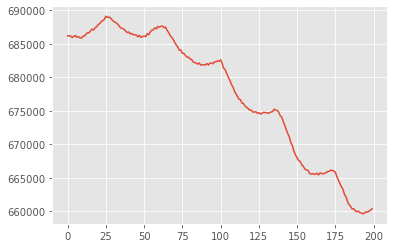

In [2]:
# select folder and subject id 
# folder = 'finger'
# subject_id = 'shawn'

# folder = 'Vital sign_0717(板榮)'
# subject_id = 'Wu_Sheng'

folder = "Vital sign_0212(Week)"
subject_id = "luke"

# specific data path
file_path = os.path.join("..\data", folder, subject_id)


G2_x, G2_y = file_read.load_ppg(file_path, 'G2')
IR_x, IR_y = file_read.load_ppg(file_path, 'IR')
R_x, R_y = file_read.load_ppg(file_path, '_R')

# quick look your raw data
plt.plot(G2_x[0:200], G2_y[0:200])

## Configuration
sampling segment, sampling rate, thresgold and plot ...

In [3]:
''' Select the duration of PPG segment in seconds'''

# sampling rate
sr = 50
acc_sr = 50

start_sec = 10
period = 10
overlap = 0.2*period

# Number of watching period 
num_watching_period = 5

data_length = len(G2_y)/sr
hop_length = period - overlap

''' Threshold '''
SNR_HR_thresh = 0.8

# Corelation coeficcient threshold for template initialize 
tm_init_cc_thr = 0.8
# Compare with template and upcomming ppg pulse
cc_thr = 0.8
num_tm_thr = 4 

''' Figure configuration'''
plot_ppg = 0 # plot figure flag
title_font_size = 16
font_size = 14
fig_size  = (12,3)
marker_size = 6



## Main

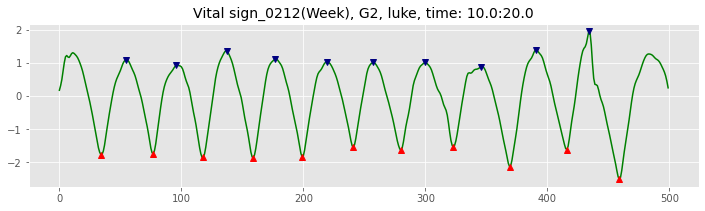

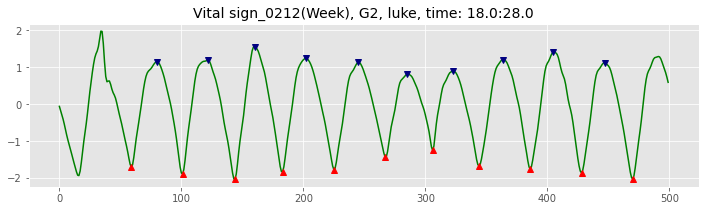

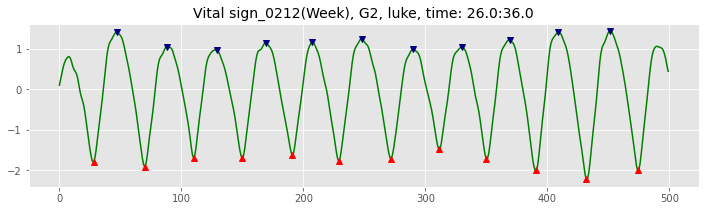

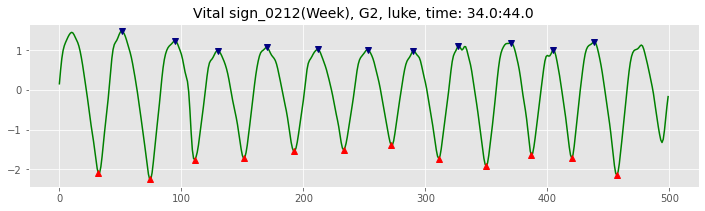

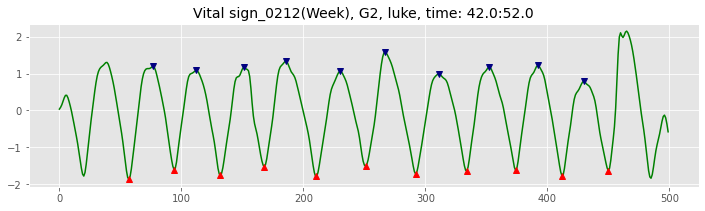

In [4]:
''' Vital sign dictionary initialize'''
mean_feat_list = {
    'subject_id': [],
    't': [],
    't1':[],
    't2':[],
    't2/t': [],
    't1/t':[],
    '1/t':[],
    'HR': [],
    'SDNN':[],
}

for n in range(num_watching_period):
    
    t1 = start_sec +  (period-overlap) * n
    t2 = t1 + period
    s1 = int(t1*sr)
    s2 = int(t2*sr )
    

    # initialize template
    tm_initial_flag = False
    tm_count=0
    tm_set = []

    # Storing single pulse and its location
    fix_pulse_set = []
    pulse_loc_set = [] # stroe two valley and peak location 

    feat_per_beat = {
        'peak':[],
        'valley':[],
        't': [],
        't1': [],
        't2': [],
        't2/t': [],
        't1/t':[],
        '1/t':[]
    }

    excellent_feat_per_beat = {
        'peak':[],
        'valley':[],
        't': [],
        't1': [],
        't2': [],
        't2/t': [],
        't1/t':[],
        '1/t':[]
    }
    excellent_beat_cnt = 0
    '''''''''''''''''''''''''''''''''''''''
    Signal Preprocessing
    '''''''''''''''''''''''''''''''''''''''
    ''' G2 preprocess'''
    # include following step
    # 1. flip up and down (if flip=1)
    # 2. bandpass filter
    # 3. normalize (if norm=1)
    G2_raw = np.array(G2_y[s1:s2])
    filtered_G2 = sp.ppg_preprocess(G2_raw, sr, norm=1,flip=1)
    G2_sample_list = np.arange(len(filtered_G2))

    '''IR Preprocess'''
    IR_raw = np.array(IR_y[s1:s2])
    filtered_IR = sp.ppg_preprocess(IR_y[s1:s2], sr, norm=1, flip=1)
    IR_sample_list = np.arange(len(filtered_IR))

    ''' R Preprocess'''
    R_raw = np.array(R_y[s1:s2])
    filtered_R = sp.ppg_preprocess(R_y[s1:s2], sr, norm=1, flip=1)
    R_sample_list = np.arange(len(filtered_R))
        

    ''' SNR Calculation'''
    h_b, h_a = sp.hp_filter(0.5, sr, 4)
    hp_G2 = signal.filtfilt(h_b, h_a, sp.flip_up_down(G2_y[s1:s2])) 
    SNR_G2 = sp.snr_calc(filtered_G2, hp_G2)


    if (SNR_G2 < SNR_HR_thresh):
        print("未配戴或需要重新配戴!, SNR G2, : ".format(SNR_G2))
        process_state = 0
    else:
        process_state = 1



    G2_peak_loc,G2_peak_time, G2_valley_loc, G2_valley_time, adap_win_size = sp.find_peak_valley(sr, filtered_G2, G2_sample_list)
#     R_peak_loc,R_peak_time, R_valley_loc, R_valley_time, adap_win_size = ppg_function.find_peak_valley(sr, filtered_R, R_sample_list)

    pulse_loc_set = sp.pulse_seg(G2_peak_loc, G2_valley_loc)
    # pulse_loc_set.extend(pulse_loc) # alllocation of pulse
    num_pulse = len(pulse_loc_set) # number of pulse in short segment

    '''''''''''''''''''''''''''''''''''''''
    Extract each pulse segment and its feature
    '''''''''''''''''''''''''''''''''''''''
    for j in range(num_pulse):
        valley1_loc = pulse_loc_set[j][0]
        valley2_loc = pulse_loc_set[j][2]
        peak_loc = pulse_loc_set[j][1]

        _v_amp = (filtered_G2[valley1_loc] + filtered_G2[valley2_loc])/2
        t = valley2_loc-valley1_loc
        feat_per_beat['peak'].append(filtered_G2[peak_loc])
        feat_per_beat['valley'].append(_v_amp)
        feat_per_beat['t'].append(t)
        feat_per_beat['t1'].append((peak_loc-valley1_loc)/sr)
        feat_per_beat['t2'].append((valley2_loc-peak_loc)/sr)
        feat_per_beat['t2/t'].append((valley2_loc-peak_loc)/t)
        feat_per_beat['t1/t'].append((peak_loc-valley1_loc)/t)
        feat_per_beat['1/t'].append(1/(t/sr))

    # Dynamic set the length of template
    template_length = int(np.median(feat_per_beat.get('t')))
    if template_length > sr*1.25:
        template_length = sr*1.25

    '''''''''''''''''''''''''''''''''''
    Template initial
    '''''''''''''''''''''''''''''''''''
    for i in range(num_pulse):
        single_filtered_ppg = sp.single_pulse_tailor(pulse_loc_set[i], filtered_G2, template_length)
        fix_pulse_set.append(single_filtered_ppg)

        if i ==0:
            ref_pulse = single_filtered_ppg
        elif i > 0:
            test_pulse = single_filtered_ppg
            cc = sp.corrcoef(test_pulse, ref_pulse)
            ref_pulse = test_pulse
            '''''''''''''''''''''''''''''''''''
            Create template
            '''''''''''''''''''''''''''''''''''
            if cc > cc_thr:
                tm_set.append(test_pulse)

    if tm_set != []:
        if len(tm_set) > num_tm_thr:
            tm_initial_flag = True
            avg_template = np.mean(tm_set, axis=0)

    '''''''''''''''''''''''''''''''''''
    plot filgure
    '''''''''''''''''''''''''''''''''''
    ylim = max(filtered_G2)
    plt.figure(figsize = fig_size)
    fig_name = folder + ', G2' +", "+ subject_id + ", time: " + str(t1) + ":" + str(t2)
    plt.title(fig_name, fontsize=font_size)
    plt.plot(G2_sample_list, filtered_G2,color='green')


    # Plot peak and valley
    if G2_peak_loc != []:
        if tm_initial_flag:
            for i in range(num_pulse):
                loc = pulse_loc_set[i][1]
                fix_pulse = fix_pulse_set[i]


                corr_socre = sp.corrcoef(avg_template, fix_pulse)


                if corr_socre < cc_thr:
                    plt.plot(loc, filtered_G2[loc], 'v', c='red', ms=marker_size)
                    plt.text(loc, filtered_G2[loc],  str(i))

                else:
                    plt.plot(loc, filtered_G2[loc], 'v', c='Navy', ms=marker_size)
                    # plt.text(loc, filtered_G2[loc], str(i))

                    '''''''''''''''''''''''''''''''''''''''
                    Excellent beat choosen by TM
                    '''''''''''''''''''''''''''''''''''''''
                    excellent_beat_cnt +=1
                    excellent_feat_per_beat['peak'].append(feat_per_beat['peak'][i])
                    excellent_feat_per_beat['valley'].append(feat_per_beat['valley'][i])
                    excellent_feat_per_beat['t'].append(feat_per_beat['t'][i])
                    excellent_feat_per_beat['t1'].append(feat_per_beat['t1'][i])
                    excellent_feat_per_beat['t2'].append(feat_per_beat['t2'][i])
                    excellent_feat_per_beat['t2/t'].append(feat_per_beat['t2/t'][i])
                    excellent_feat_per_beat['t1/t'].append(feat_per_beat['t1/t'][i])
                    excellent_feat_per_beat['1/t'].append(feat_per_beat['1/t'][i])

        else:
            plt.plot(G2_peak_loc, filtered_G2[G2_peak_loc], '^', c='purple', ms=marker_size, label='ppg peak')

    if G2_valley_loc != []:
        plt.plot(G2_valley_loc, filtered_G2[G2_valley_loc], '^', c='red', ms=marker_size, label='ppg valley')


    # plt.savefig('../figure/sqi_test/' + folder + '_G2_' + subject_id + '_' + str(start_sec) + ':'+str(stop_sec) + '.png')
    
    # Plot IR
#     plt.figure(figsize=(12,3))
#     plt.title('IR' +", "+ subject_id + ", time: "  + str(start_sec) + ":" + str(start_sec + period),fontsize=font_size)
#     plt.plot(IR_sample_list, filtered_IR, color='blue')
#     plt.plot(IR_peak_loc, filtered_IR[IR_peak_loc], 'v', c='navy', ms=marker_size, label='peak')
#     plt.plot(IR_valley_loc, filtered_IR[IR_valley_loc], '^', c='green', ms=marker_size, label='valley')

    # Plot red light peak and valley
#     plt.figure(figsize=(12,3))
#     plt.title('R' +", "+ subject_id + ", time: "  + str(start_sec) + ":" + str(start_sec + period),  fontsize=font_size)
#     plt.plot(R_sample_list, filtered_R, color='orangered')
    # plt.plot(R_peak_loc, filtered_R[R_peak_loc], 'v', c='navy', ms=marker_size, label='peak')
    # plt.plot(R_valley_loc, filtered_R[R_valley_loc], '^', c='green', ms=marker_size, label='valley')
    
#     # Plot raw data
#     plt.figure(figsize=(12,5))
#     plt.title('G2 raw' +", "+ subject_id + ", time: "  + str(start_sec) + ":" + str(start_sec + period),  fontsize=font_size)
#     plt.plot(G2_raw, color='green')
#     plt.plot(G2_peak_loc, G2_raw[G2_peak_loc], 'v', c='navy', ms=marker_size, label='peak')
#     plt.plot(G2_valley_loc, G2_raw[G2_valley_loc], '^', c='cyan', ms=marker_size, label='valley')
    
#     plt.figure(figsize=(12,5))
#     plt.title('R raw' +", "+ subject_id + ", time: "  + str(start_sec) + ":" + str(start_sec + period),  fontsize=font_size)
#     plt.plot(R_raw, color='orange')
#     plt.plot(G2_peak_loc, R_raw[G2_peak_loc], 'v', c='navy', ms=marker_size, label='peak')
#     plt.plot(G2_valley_loc, R_raw[G2_valley_loc], '^', c='cyan', ms=marker_size, label='valley')
    
    
    
    ''' Peak to Peak Interval '''
    # Only take excellent pulse
    ppi_list = []
    for k in range(1,excellent_beat_cnt):
        ppi = excellent_feat_per_beat['t2'][k-1] + excellent_feat_per_beat['t1'][k]
        ppi_list.append(ppi)


    mean_feat_list['subject_id'].append(subject_id + ':' + str(t1) + ':' + str(t2))
    if excellent_beat_cnt >1:
        mean_duration = np.mean(excellent_feat_per_beat['t']) / sr
        mean_t1 = np.mean(excellent_feat_per_beat['t1']) 
        mean_t2 = np.mean(excellent_feat_per_beat['t2'])
        mean_systole = np.mean(excellent_feat_per_beat['t1/t'])
        mean_diastole = np.mean(excellent_feat_per_beat['t2/t'])
        mean_hb = np.mean(excellent_feat_per_beat['1/t'])
        sdnn = np.std(ppi_list) *1000

        mean_feat_list['t'].append(mean_duration)
        mean_feat_list['t1'].append(mean_t1)
        mean_feat_list['t2'].append(mean_t2)
        mean_feat_list['t1/t'].append(mean_systole)
        mean_feat_list['t2/t'].append(mean_diastole)
        mean_feat_list['1/t'].append(mean_hb)
        mean_feat_list['HR'].append(mean_hb*60)
        mean_feat_list['SDNN'].append(sdnn)
    else: 
        mean_feat_list['t'].append(None)
        mean_feat_list['t1'].append(None)
        mean_feat_list['t2'].append(None)
        mean_feat_list['t1/t'].append(None)
        mean_feat_list['t2/t'].append(None)
        mean_feat_list['1/t'].append(None)
        mean_feat_list['HR'].append(None)
        mean_feat_list['SDNN'].append(None)

## Feature dataframe

In [16]:
feat_df = pd.DataFrame(mean_feat_list)
feat_df

,subject_id,t,t1,t2,t2/t,t1/t,1/t,HR,SDNN
0,shawn:3.0:13.0,0.756364,0.247273,0.509091,0.672686,0.327314,1.324636,79.478156,33.526109
1,shawn:11.0:21.0,0.782000,0.250000,0.532000,0.680175,0.319825,1.279691,76.781457,29.814240
2,shawn:19.0:29.0,0.749091,0.238182,0.510909,0.681345,0.318655,1.338862,80.331714,36.932371
3,shawn:27.0:37.0,0.738182,0.274545,0.463636,0.626414,0.373586,1.365384,81.923023,125.872952
4,shawn:35.0:45.0,0.772727,0.270909,0.501818,0.649077,0.350923,1.299047,77.942843,103.846040
